# College Football Conference Strength

Many have proposed various methods for declaring what FBS College Football conference is "The Strongest Conference". Some could cite the number of National Championships, Bowl games, highest ratings, game attendance, or even revenue. 

This analysis seeks to see the trends (season-to-season for the last 100 years) of conference strength defined as the non-conference win percentage for that conference. This win percentage is calcuated by taking all the non-conference games across all teams for a conference, finding the win/loss/tie outcome (encoded 1/0/0.5 respectively), and then taking the average of the outcomes. If a conference is strong, then it should win their non-conference games. If they are weak, then they should loose their non-conference games. Furthermore, this method relies less on opinion of polls or limitation of stadium attendance.

# Methodology Notes:
   1. I pulled data from 1923 and on, but could have gone back further.
   2. Vacated wins are not vacated in this analysis.
   3. Ties counted as a half-win.
   4. I considered defunct conferences for the calculation of non-conference wins, but did not show the defunct conferences in the graphics.
   5. I tried to capture when conferences re-branded vs. collapsed. For example, when the PAC 10 became the PAC 12, I considered that the same conference (SEC did not re-brand when they added schools!). However, the exact ones to choose are up for debate.
   6. This approach follows the brand of a conference over time.
   
# Interesting findings:
   1. Under these metrics, there is weight to the argument that the SEC is the best conference in college football. Their non-conference win percentage was the highest in average and median over their existence. The variance of the win percentage was small as well.
   2. Keep an eye on the Sun Belt, they could be a rising star. (successor Power 5 program?)
   3. Today's Power 5 Conferences have been steadily growing in strength starting in the 1950's-70's (depending on the conference), but seem to have plateaued over the last 20 years.
   4. Independents have been holding at about 50% for the last 100 years. This differs from the patterns from the other conferences

# Perform Analysis
## Import Packages

In [1]:
# import packages
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cfbd
import os

## Pull and Save Data

In [2]:
# define variables

pull_data = False
fileName = "100_Year_Football_Data.csv"


In [3]:
# Pull data from website

if pull_data:
    api_key = '[see instruction on https://collegefootballdata.com/ under the API tab]'
    
    configuration = cfbd.Configuration()
    configuration.api_key['Authorization'] = api_key
    configuration.api_key_prefix['Authorization'] = 'Bearer'
    
    api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
    
    all_games = []
    
    for season in range(1923,2025):
        print(season)
        games = api_instance.get_games(year=season)
        all_games.extend(games)
    
    
    games_as_list = [{k:v if k not in ['away_line_scores', 'home_line_scores'] else None for k,v in all_games[0].to_dict().items()}]
    games_df = pd.DataFrame({k:[v] for k,v in all_games[0].to_dict().items()})
    for game in range(1, len(all_games)):
        
        games_as_list.extend([{k:v if k not in ['away_line_scores', 'home_line_scores'] else None for k,v in all_games[game].to_dict().items()}])
    
    games_df = pd.DataFrame.from_records(games_as_list)
    games_df.to_csv(fileName, index = False)


## Read Data In

In [4]:
# pull data localy and clean data

games_df = pd.read_csv(fileName)


C:\Users\Daniel-PC\AppData\Local\Temp\ipykernel_1192\1867667251.py:3: DtypeWarning: Columns (5,8,11,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv(fileName)


In [5]:
games_df.columns

Index(['id', 'season', 'week', 'season_type', 'start_date', 'start_time_tbd',
       'completed', 'neutral_site', 'conference_game', 'attendance',
       'venue_id', 'venue', 'home_id', 'home_team', 'home_conference',
       'home_division', 'home_points', 'home_line_scores',
       'home_post_win_prob', 'home_pregame_elo', 'home_postgame_elo',
       'away_id', 'away_team', 'away_conference', 'away_division',
       'away_points', 'away_line_scores', 'away_post_win_prob',
       'away_pregame_elo', 'away_postgame_elo', 'excitement_index',
       'highlights', 'notes'],
      dtype='object')

In [6]:
games_df.head()

,id,season,week,season_type,start_date,start_time_tbd,completed,neutral_site,conference_game,attendance,...,away_conference,away_division,away_points,away_line_scores,away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index,highlights,notes
0,12768,1923,1,regular,1923-09-22T00:00:00.000Z,NaN,True,False,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12767,1923,1,regular,1923-09-22T00:00:00.000Z,NaN,True,False,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12766,1923,1,regular,1923-09-22T00:00:00.000Z,NaN,True,False,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12765,1923,1,regular,1923-09-22T00:00:00.000Z,NaN,True,False,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12764,1923,1,regular,1923-09-22T00:00:00.000Z,NaN,True,False,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
games_df.tail()

,id,season,week,season_type,start_date,start_time_tbd,completed,neutral_site,conference_game,attendance,...,away_conference,away_division,away_points,away_line_scores,away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index,highlights,notes
89978,401635640,2024,14,regular,2024-12-01T01:00:00.000Z,False,False,False,True,NaN,...,ACC,fbs,NaN,NaN,NaN,1399.0,NaN,NaN,NaN,NaN
89979,401643846,2024,14,regular,2024-12-01T01:00:00.000Z,False,False,False,True,NaN,...,Sun Belt,fbs,NaN,NaN,NaN,1489.0,NaN,NaN,NaN,NaN
89980,401643771,2024,14,regular,2024-12-01T04:00:00.000Z,False,False,False,True,NaN,...,Mountain West,fbs,NaN,NaN,NaN,1269.0,NaN,NaN,NaN,NaN
89981,401673471,2024,15,regular,2024-12-07T19:00:00.000Z,False,False,False,True,NaN,...,SWAC,fcs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SWAC Championship
89982,401645383,2024,16,regular,2024-12-14T20:00:00.000Z,False,False,True,True,NaN,...,American Athletic,fbs,NaN,NaN,NaN,1477.0,NaN,NaN,NaN,NaN


In [8]:
len(games_df)

89983

## Filter for FBS vs. FBS only and Completed Games

In [9]:
fbs_only_df = games_df[(games_df['home_division']=='fbs')&
                       (games_df['away_division']=='fbs')&
                       (games_df['completed']==True)]


In [10]:
fbs_only_df.head()

,id,season,week,season_type,start_date,start_time_tbd,completed,neutral_site,conference_game,attendance,...,away_conference,away_division,away_points,away_line_scores,away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index,highlights,notes
14,12776,1923,2,regular,1923-09-29T00:00:00.000Z,NaN,True,False,NaN,NaN,...,Southern,fbs,0.0,NaN,NaN,1689.0,1551.0,NaN,NaN,NaN
33,12814,1923,2,regular,1923-09-29T00:00:00.000Z,NaN,True,False,NaN,NaN,...,FBS Independents,fbs,2.0,NaN,NaN,1065.0,1080.0,NaN,NaN,NaN
41,12806,1923,2,regular,1923-09-29T00:00:00.000Z,NaN,True,False,NaN,NaN,...,FBS Independents,fbs,0.0,NaN,NaN,1213.0,1200.0,NaN,NaN,NaN
49,12797,1923,2,regular,1923-09-29T00:00:00.000Z,NaN,True,False,NaN,NaN,...,Southwest,fbs,0.0,NaN,NaN,1459.0,1439.0,NaN,NaN,NaN
50,12796,1923,2,regular,1923-09-29T00:00:00.000Z,NaN,True,False,NaN,NaN,...,FBS Independents,fbs,13.0,NaN,NaN,1389.0,1392.0,NaN,NaN,NaN


In [11]:
fbs_only_df.tail()

,id,season,week,season_type,start_date,start_time_tbd,completed,neutral_site,conference_game,attendance,...,away_conference,away_division,away_points,away_line_scores,away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index,highlights,notes
89759,401644770,2024,13,regular,2024-11-20T00:30:00.000Z,False,True,False,True,NaN,...,Mid-American,fbs,14.0,NaN,0.064013,1249.0,1242.0,6.396420,NaN,NaN
89760,401644690,2024,13,regular,2024-11-20T01:00:00.000Z,False,True,False,True,NaN,...,Mid-American,fbs,9.0,NaN,0.153255,1464.0,1450.0,5.088202,NaN,NaN
89761,401644773,2024,13,regular,2024-11-21T00:00:00.000Z,False,True,False,True,NaN,...,Mid-American,fbs,24.0,NaN,0.883110,1546.0,1588.0,5.909186,NaN,NaN
89762,401644772,2024,13,regular,2024-11-21T00:00:00.000Z,False,True,False,True,NaN,...,Mid-American,fbs,37.0,NaN,0.763445,1217.0,1263.0,3.316440,NaN,NaN
89764,401634772,2024,13,regular,2024-11-22T00:30:00.000Z,False,True,False,True,NaN,...,ACC,fbs,29.0,NaN,0.403971,1499.0,1501.0,7.966406,NaN,NaN


In [12]:
len(fbs_only_df)

56662

## How many completed FBS games were played by season?

<Axes: xlabel='season'>

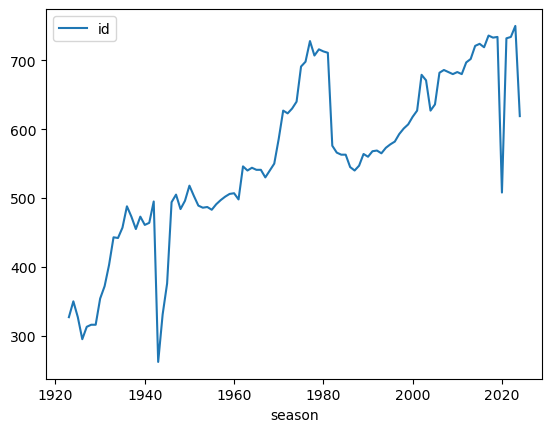

In [13]:
games_per_season_count = fbs_only_df.groupby('season')['id'].nunique().reset_index()
games_per_season_count.plot('season', 'id')



The valley in the 1940's could likely be due to WW2
The valley in the 1980's could be the introcuction of Division 1 AA (today called FCS)
The valley in the 2020 coudl be the COVID-19 Pandemic restrictions

## How many FBS teams played by season?

<Axes: xlabel='season'>

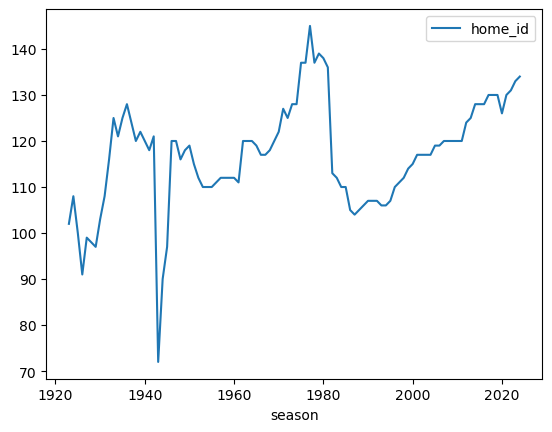

In [14]:
teams_per_season_count = fbs_only_df.groupby('season')['home_id'].nunique().reset_index()
teams_per_season_count.plot('season', 'home_id')

The valley in the 1940's could likely be due to WW2

The valley in the 1980's could be the introcuction of Division 1 AA (today called FCS)

## Fix old conference names to present-day ones

In [15]:

# Set old conference names to the current name 
fbs_only_df.loc[(fbs_only_df['home_conference']=="Pacific") |
                (fbs_only_df['home_conference']=="Pac-8") |
                (fbs_only_df['home_conference']=="Pac-10") |
                (fbs_only_df['home_conference']=="AAWU"), 'home_conference']='Pac-12'

fbs_only_df.loc[(fbs_only_df['away_conference']=="Pacific") |
                (fbs_only_df['away_conference']=="Pac-8") |
                (fbs_only_df['away_conference']=="Pac-10") |
                (fbs_only_df['away_conference']=="AAWU"), 'away_conference']='Pac-12'

fbs_only_df.loc[(fbs_only_df['home_conference']=="PCAA"), 'home_conference']='Big West'
fbs_only_df.loc[(fbs_only_df['away_conference']=="PCAA"), 'away_conference']='Big West'

fbs_only_df.loc[(fbs_only_df['home_conference']=="Western"), 'home_conference']='Big Ten'
fbs_only_df.loc[(fbs_only_df['away_conference']=="Western"), 'away_conference']='Big Ten'

fbs_only_df.loc[(fbs_only_df['home_conference']=="Big East"), 'home_conference']='American Athletic'
fbs_only_df.loc[(fbs_only_df['away_conference']=="Big East"), 'away_conference']='American Athletic'

fbs_only_df.loc[(fbs_only_df['home_conference']=="Big 8") |
                (fbs_only_df['home_conference']=="Big 6") |
                (fbs_only_df['home_conference']=="Missouri Valley") |
                (fbs_only_df['home_conference']=="Big 7"), 'home_conference']='Big 12'

fbs_only_df.loc[(fbs_only_df['away_conference']=="Big 8") |
                (fbs_only_df['away_conference']=="Big 6") |
                (fbs_only_df['away_conference']=="Missouri Valley") |
                (fbs_only_df['away_conference']=="Big 7"), 'away_conference']='Big 12'


## Identify the outcome

In [16]:
fbs_only_df['home_outcome'] = None
fbs_only_df.loc[(fbs_only_df['home_points']==fbs_only_df['away_points']), 'home_outcome'] = 'Tie'
fbs_only_df.loc[(fbs_only_df['home_points']>fbs_only_df['away_points']), 'home_outcome'] = 'Win'
fbs_only_df.loc[(fbs_only_df['home_points']<fbs_only_df['away_points']), 'home_outcome'] = 'Loss'

fbs_only_df['away_outcome'] = None
fbs_only_df.loc[(fbs_only_df['home_outcome']=='Tie'), 'away_outcome'] = 'Tie'
fbs_only_df.loc[(fbs_only_df['home_outcome']=='Loss'), 'away_outcome'] = 'Win'
fbs_only_df.loc[(fbs_only_df['home_outcome']=='Win'), 'away_outcome'] = 'Loss'


C:\Users\Daniel-PC\AppData\Local\Temp\ipykernel_1192\1408220933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbs_only_df['home_outcome'] = None
C:\Users\Daniel-PC\AppData\Local\Temp\ipykernel_1192\1408220933.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbs_only_df['away_outcome'] = None


## Filter for non-conference games only

In [17]:

# keep only the out of conference matchups
fbs_only_df['adjusted_in_conference'] = fbs_only_df['home_conference']==fbs_only_df['away_conference']
fbs_non_conference= fbs_only_df[~fbs_only_df['adjusted_in_conference']]


C:\Users\Daniel-PC\AppData\Local\Temp\ipykernel_1192\2662882209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbs_only_df['adjusted_in_conference'] = fbs_only_df['home_conference']==fbs_only_df['away_conference']


In [18]:
len(fbs_non_conference)

18556

## What conferences tend to play each other?

In [19]:
# Import seaborn library
import seaborn as sns
 
# Declaring the cm variable by the 
# color palette from seaborn
cm = sns.light_palette("blue", as_cmap=True)

current_conferences = ['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt', 'FBS Independents']
to_plot = fbs_non_conference[fbs_non_conference['home_conference'].isin(current_conferences) &
                             fbs_non_conference['away_conference'].isin(current_conferences)]

conference_matchups_part_1 = to_plot[['home_conference', 'away_conference', 'id']].pivot_table(index = 'home_conference', columns = 'away_conference', aggfunc = 'count')
conference_matchups_part_2 = to_plot[['home_conference', 'away_conference', 'id']].pivot_table(index = 'away_conference', columns = 'home_conference', aggfunc = 'count')
conference_matchups_overall = conference_matchups_part_1+conference_matchups_part_2
# Visualizing the DataFrame with set precision
conference_matchups_overall.style.background_gradient(cmap=cm).set_precision(2)


C:\Users\Daniel-PC\AppData\Local\Temp\ipykernel_1192\864915505.py:16: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  conference_matchups_overall.style.background_gradient(cmap=cm).set_precision(2)


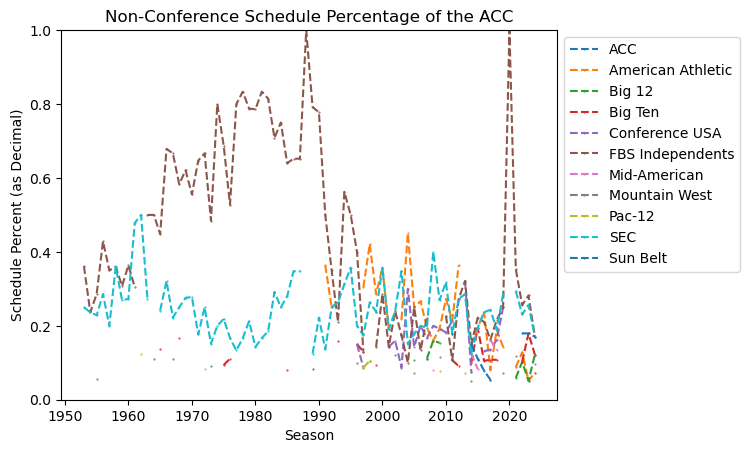

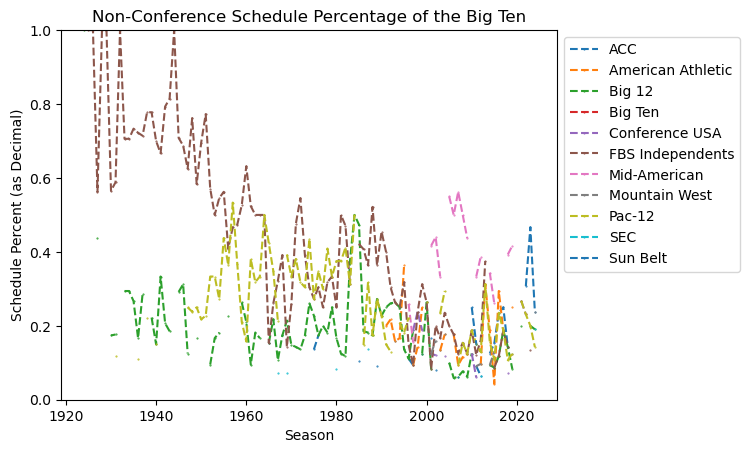

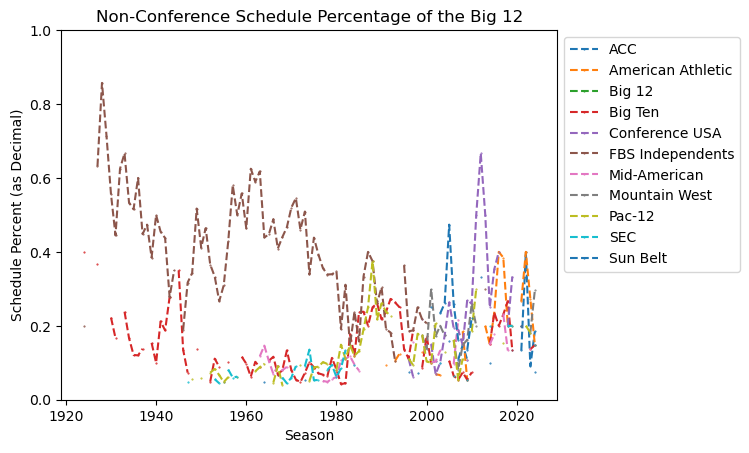

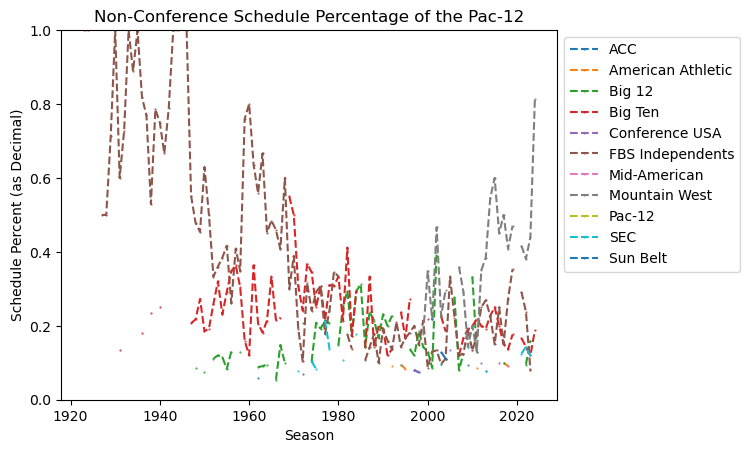

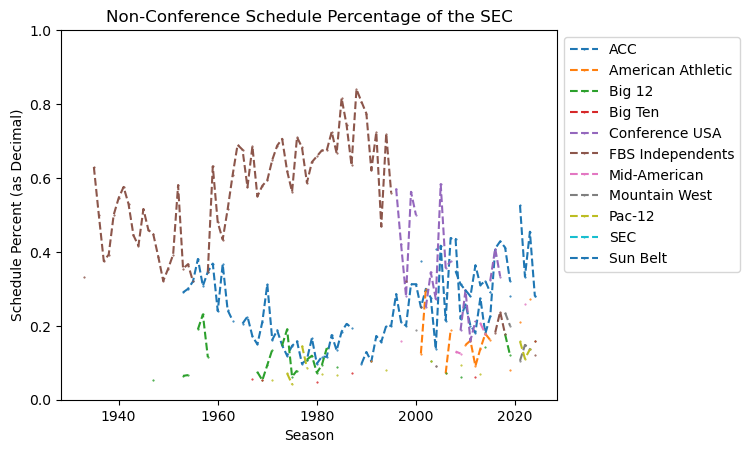

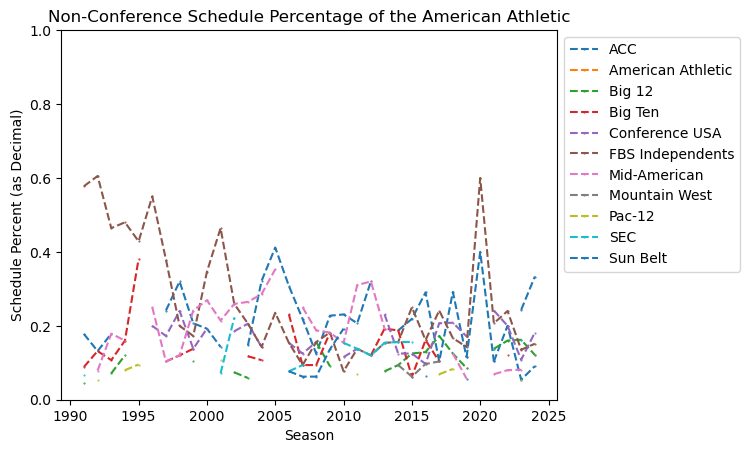

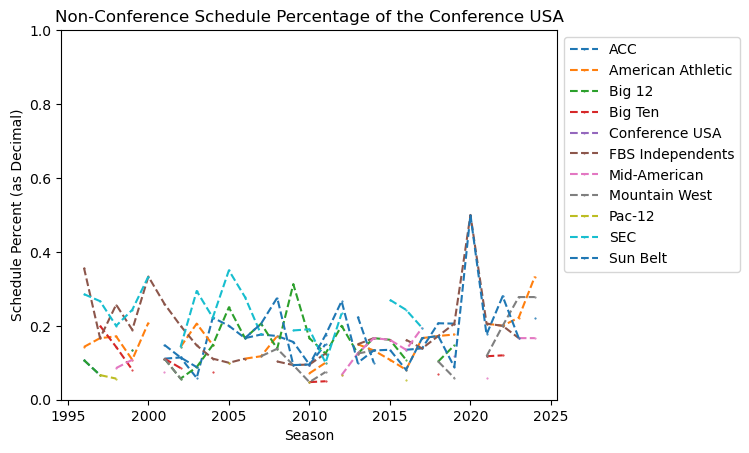

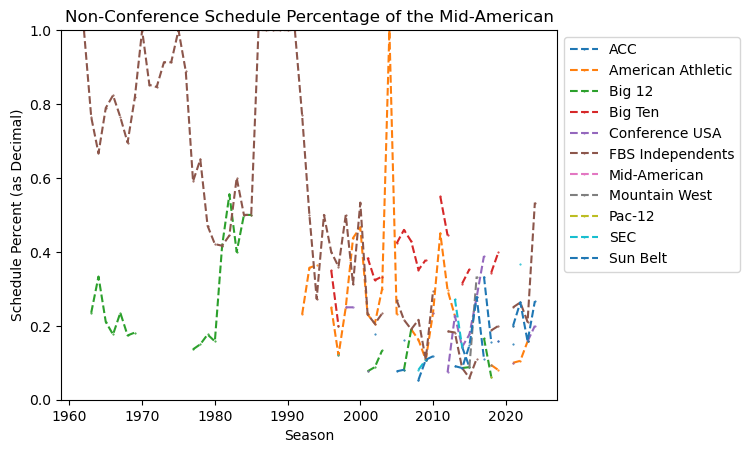

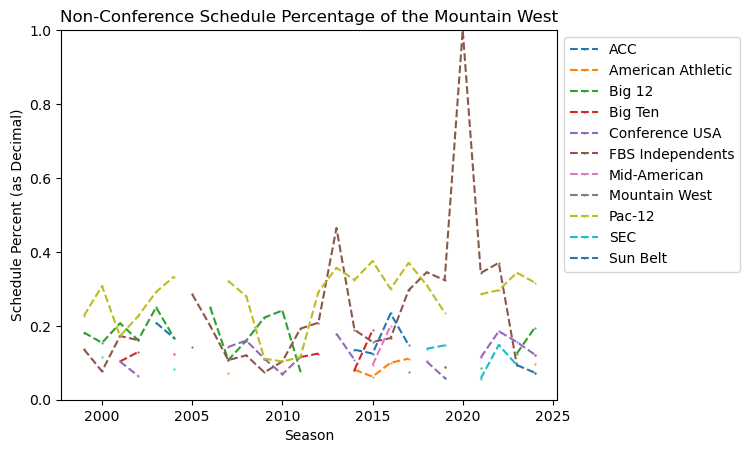

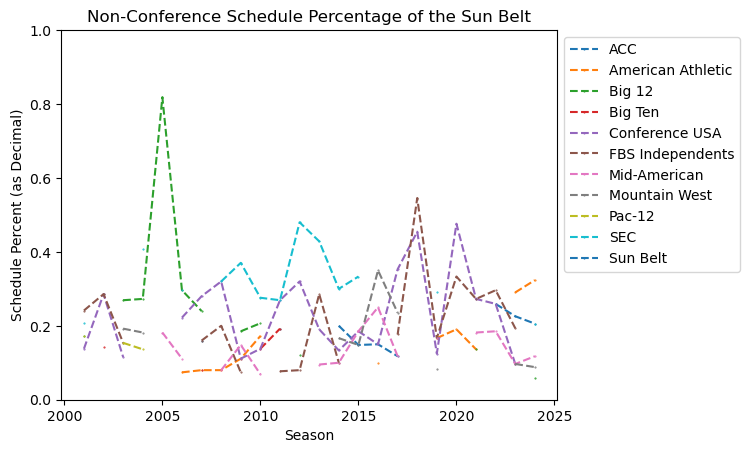

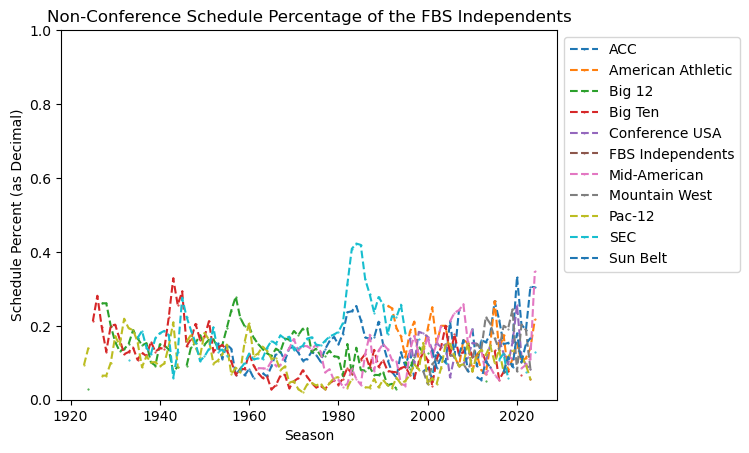

In [20]:
current_conferences = ['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt', 'FBS Independents']

to_plot = fbs_non_conference.copy()
conference_matchups_part_1 = to_plot[['season', 'home_conference', 'away_conference', 'id']].pivot_table(index = ['season', 'home_conference'], columns = 'away_conference', aggfunc = 'count')
conference_matchups_part_2 = to_plot[['season', 'home_conference', 'away_conference', 'id']].pivot_table(index = ['season', 'away_conference'], columns = 'home_conference', aggfunc = 'count')
conference_matchups_part_2.index.names = ['season', 'home_conference']
conference_matchups_overall = conference_matchups_part_1+conference_matchups_part_2
conference_matchups_overall_sum = conference_matchups_overall.groupby(level=0).transform('sum')
conference_matchups_overall_percent = conference_matchups_overall/conference_matchups_overall_sum

conference_matchups_overall_percent.columns = conference_matchups_overall_percent.columns.get_level_values(1)
conference_matchups_overall_percent = conference_matchups_overall_percent.reset_index()

conference_matchups_overall_percent = conference_matchups_overall_percent[conference_matchups_overall_percent['home_conference'].isin(current_conferences)]

for current_conference in current_conferences:
    data_to_plot = conference_matchups_overall_percent.pivot(index='season', columns='home_conference')[current_conference]
    data_to_plot.plot(ylim = [0,1], style='o--', ms = 0.5)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(f"Non-Conference Schedule Percentage of the {current_conference}")
    plt.ylabel("Schedule Percent (as Decimal)")
    plt.xlabel("Season")
    plt.show()


From this, it appears that there are no strong bilatteral scheduling ties (formal or in-formal) active conferences. There may be the exception of the Pac-12 and Mountain West playing each other a lot.

## Restructure the data

In [21]:
fbs_non_conference_0 = fbs_non_conference[['season', 'week', 'home_id', 'home_team', 'home_conference', 'home_outcome']]
fbs_non_conference_1 = fbs_non_conference[['season', 'week', 'away_id', 'away_team', 'away_conference', 'away_outcome']]

fbs_non_conference_0.rename({'home_id': 'school_id',
                             'home_team': 'team',
                             'home_conference': 'conference',
                             'home_outcome': 'outcome'}, inplace = True, axis = 'columns')

fbs_non_conference_1.rename({'away_id': 'school_id',
                             'away_team': 'team',
                             'away_conference': 'conference',
                             'away_outcome': 'outcome'}, inplace = True, axis = 'columns')

fbs_non_conference_by_school = pd.concat([fbs_non_conference_0, fbs_non_conference_1])


C:\Users\Daniel-PC\AppData\Local\Temp\ipykernel_1192\1336621853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbs_non_conference_0.rename({'home_id': 'school_id',
C:\Users\Daniel-PC\AppData\Local\Temp\ipykernel_1192\1336621853.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fbs_non_conference_1.rename({'away_id': 'school_id',


## Encode win/loss/tie as a number

In [22]:
fbs_non_conference_by_school = fbs_non_conference_by_school.replace({'outcome': {'Win': 1, 'Loss':0, 'Tie':0.5}})


#find the number of non-conference games played of each conference by season
fbs_non_conference_game_count = fbs_non_conference_by_school.groupby(['season', 'conference'])['outcome'].count().reset_index()
fbs_non_conference_game_count.rename({'outcome':'non_conference_games'}, inplace = True, axis = 'columns')

#find the average win percentage of each conference by season
fbs_non_conference_record = fbs_non_conference_by_school.groupby(['season', 'conference'])['outcome'].mean().reset_index()

fbs_non_conference_record = fbs_non_conference_record.merge(fbs_non_conference_game_count, how = 'left')

In [23]:
fbs_non_conference_record.describe()

,season,outcome,non_conference_games
count,1063.000000,1063.000000,1063.000000
mean,1976.637817,0.497412,34.912512
std,28.223175,0.174545,23.305449
min,1923.000000,0.000000,1.000000
25%,1954.000000,0.375000,24.000000
50%,1977.000000,0.500000,31.000000
75%,2001.000000,0.625000,39.000000
max,2024.000000,1.000000,184.000000


array([[<Axes: title={'center': 'non_conference_games'}>]], dtype=object)

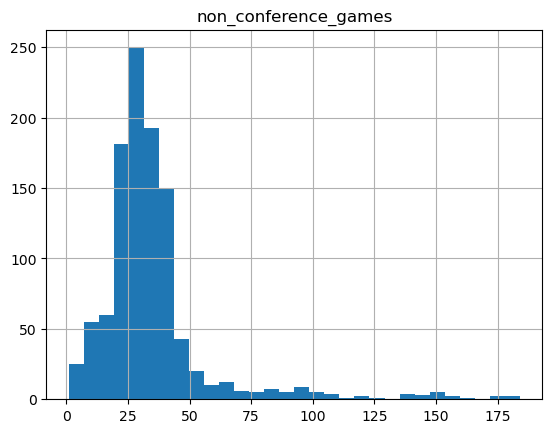

In [24]:
fbs_non_conference_record[['non_conference_games']].hist(bins=30)

## Only keep out of conference records that were from 10 games or more

In [25]:
fbs_non_conference_record = fbs_non_conference_record[fbs_non_conference_record['non_conference_games']>=10]

In [26]:
# compute some quick stats
stats = pd.DataFrame({
"mean":fbs_non_conference_record.groupby('conference')['outcome'].mean(),
"median":fbs_non_conference_record.groupby('conference')['outcome'].median(),
"variance":fbs_non_conference_record.groupby('conference')['outcome'].var()})

stats.sort_values("mean", ascending=False)

,mean,median,variance
conference,,,
SEC,0.709744,0.714286,0.008029
Big Ten,0.609539,0.625000,0.016644
Pac-12,0.583987,0.586207,0.015007
Southwest,0.555824,0.568574,0.013583
American Athletic,0.535299,0.534109,0.016602
Big 12,0.524840,0.503968,0.023859
ACC,0.505778,0.525000,0.017537
FBS Independents,0.479533,0.483598,0.008241
Southland,0.473180,0.544118,0.012200


## Plot Non-Conference Win Percent with a Trend Line
Create a plot for different conferences that has the scatterplot of win percentages with some MSE and RMSE plots to help find  a good ballance of meaningfully fitting a curve to a line without overfitting


In [27]:
smoothing_dict = {'Big Ten' : 0.9,
'Pac-12': 1.1,
'SEC' : 0.4,
'Big 12': 0.5,
'ACC': 0.5,
'American Athletic':0.3,
'Conference USA':0.07, 
'Mid-American':0.3, 
'Mountain West':0.2, 
'Sun Belt':0.2}

def print_one_conference(fbs_non_conference_record, conference, smoothing_factor):
    to_plot = fbs_non_conference_record[fbs_non_conference_record['conference']==conference]
    table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')
    #table.plot(ylim=[0,1])
    
    spline_df = pd.DataFrame()
    
    temp = table[[conference]].dropna()
    s = UnivariateSpline(temp.index.to_list(), temp[conference], s=smoothing_factor)
    xs = np.linspace(min(temp.index.to_list()), max(temp.index.to_list()), 1000)
    ys = s(xs)
    spline_df['Best-fit Line'] = ys
    
    spline_df.set_index(xs, inplace = True)
    all_spline_df = table.join(spline_df, how = 'outer')
    all_spline_df.plot(ylim = [0,1], style='o-', ms = 0.5)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(f"Non-Conference Win Percentage of the {conference}\nSmoothing factor: {smoothing_factor}")
    plt.ylabel("Win Percent (as Decimal)")
    plt.xlabel("Season")
    plt.savefig(f'{conference}.png', dpi=200, bbox_inches = 'tight')
    plt.show()
    
    df = pd.DataFrame(columns=['smooth', 'MSE'])
    for x in range(0,100):
        
        s = UnivariateSpline(temp.index.to_list(), temp[conference], s=x/100)
        
        df = pd.concat([df, pd.DataFrame(data={'smoothing factor' : x/100, 
                                               'MSE': mean_squared_error(s(temp.index.to_list()), temp[conference]), 
                                               'RMSE': mean_squared_error(s(temp.index.to_list()), temp[conference], squared = False)}, index = [0])])
    
    # If desired, the smoothing factors can be plotted to help optimize smoothing factor choices
    # df.plot("smoothing factor", 'MSE')
    # df.plot("smoothing factor", 'RMSE')

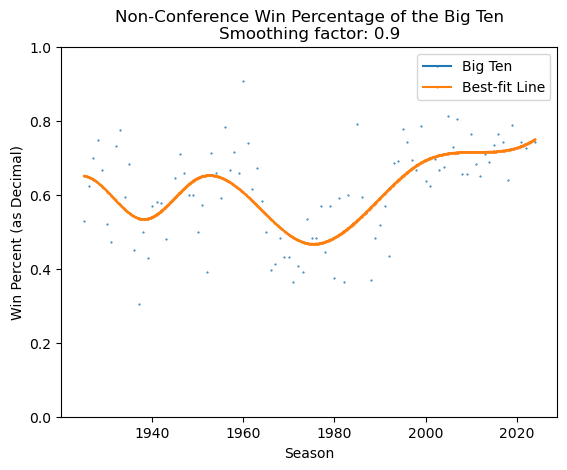

In [28]:
conference = 'Big Ten'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

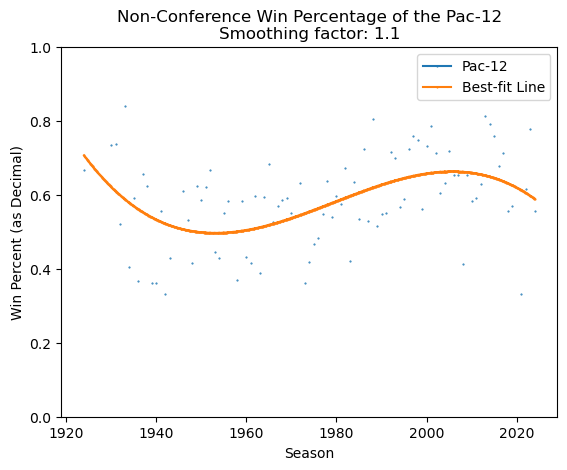

In [29]:
conference = 'Pac-12'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

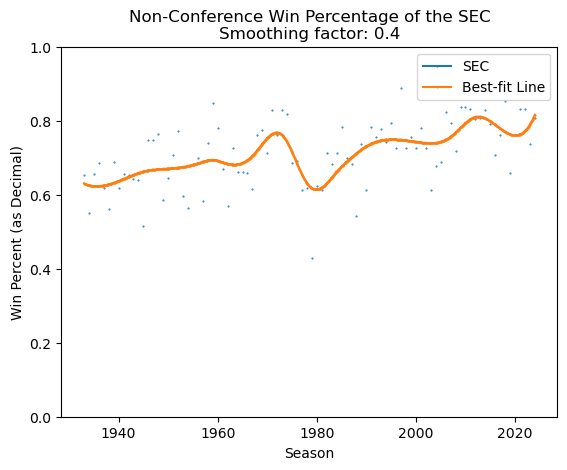

In [30]:
conference = 'SEC'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

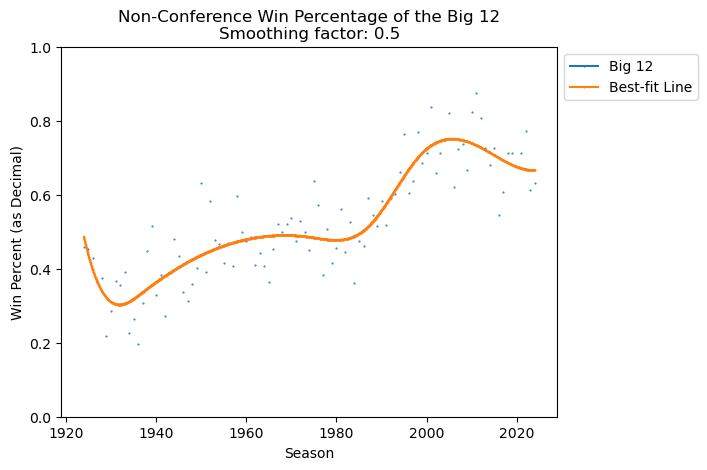

In [31]:
conference = 'Big 12'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

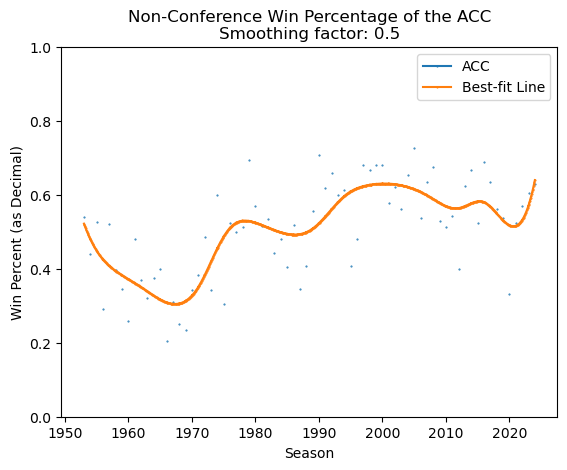

In [32]:
conference = 'ACC'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

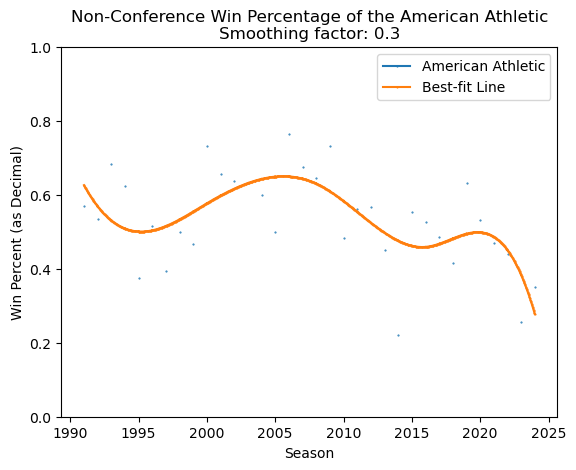

In [33]:
conference = 'American Athletic'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

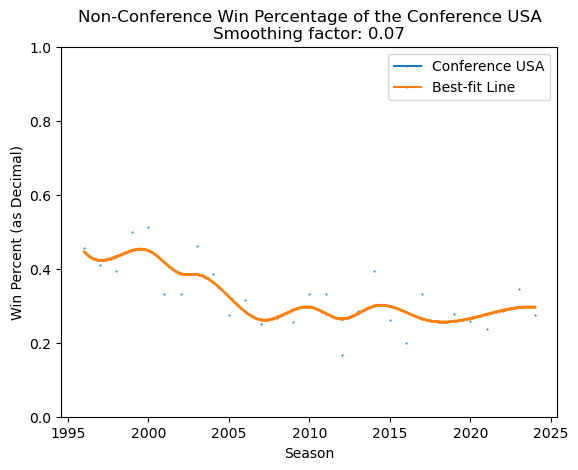

In [34]:
conference = 'Conference USA'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

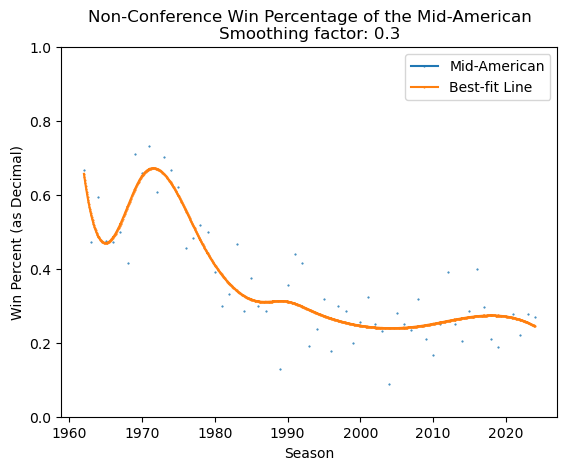

In [35]:
conference = 'Mid-American'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

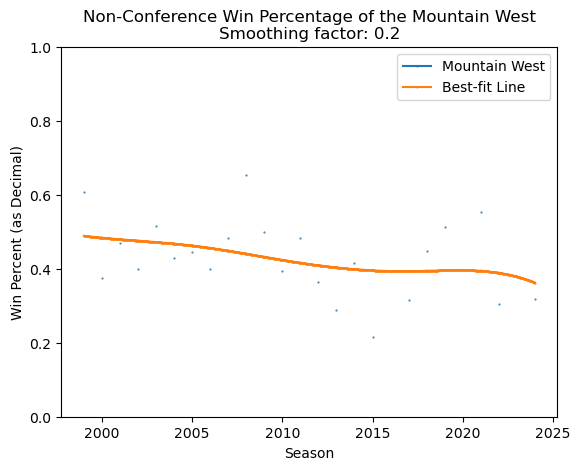

In [36]:
conference = 'Mountain West'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

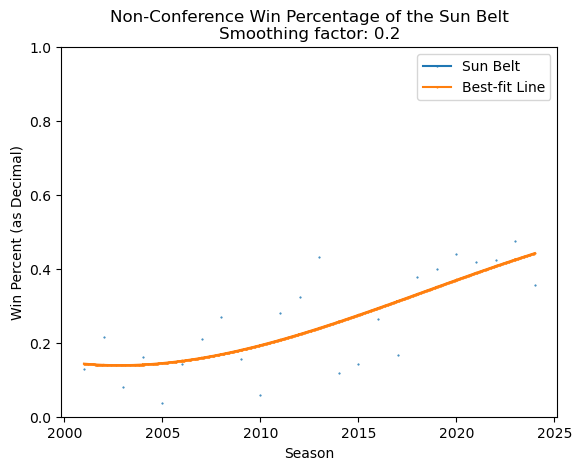

In [37]:
conference = 'Sun Belt'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

## Print Conference Trend Lines All Together

In [38]:

#%% print conference charts

def print_chart(table, title, save_loc):
    all_spline_df = pd.DataFrame()
    
    counter = 0
    for conference in table.columns:
        counter += 1
    
        spline_df = pd.DataFrame()
    
        temp = table[[conference]].dropna()
        s = UnivariateSpline(temp.index.to_list(), temp[conference], s=smoothing_dict.get(conference,0.75))
        xs = np.linspace(min(temp.index.to_list()), max(temp.index.to_list()), 1000)
        ys = s(xs)
        spline_df[conference] = ys
    
        spline_df.set_index(xs, inplace = True)
        try:
            all_spline_df = all_spline_df.join(spline_df, how = 'outer')
        except:
            all_spline_df = spline_df
        
        if counter ==11:
            counter = 0
            all_spline_df.sort_index().plot(ylim = [0,1], marker='o', ms = 0.5)
            all_spline_df = pd.DataFrame()
            spline_df = pd.DataFrame()
            plt.legend(bbox_to_anchor=(1.0, 1.0))
            plt.title(title)
            plt.ylabel("Win Percent (as Decimal)")
            plt.xlabel("Season")
            plt.savefig(save_loc, dpi = 200, bbox_inches = 'tight')
            plt.show()
    
    all_spline_df.plot(ylim = [0,1], marker='o', ms = 0.5)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(title)
    plt.ylabel("Win Percent (as Decimal)")
    plt.xlabel("Season")
    plt.savefig(save_loc, dpi=200, bbox_inches = 'tight')


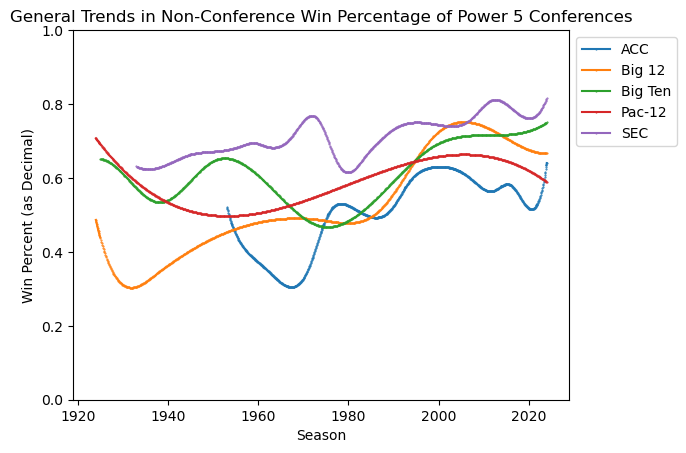

In [39]:

# Power 5
to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of Power 5 Conferences', 'power-5.png')


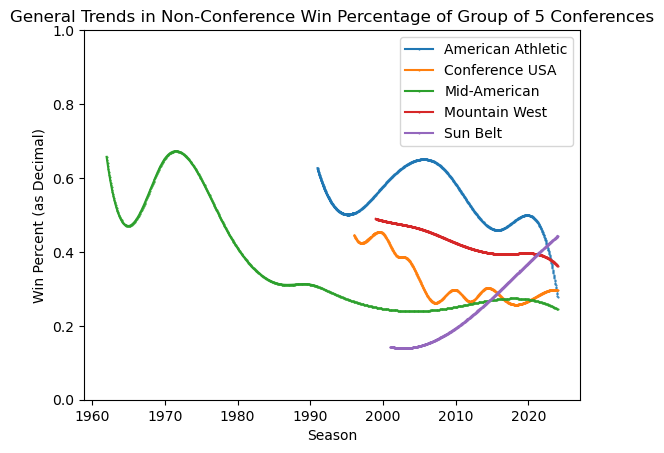

In [40]:
# Group of 5
 
to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of Group of 5 Conferences', 'group-of-5.png')



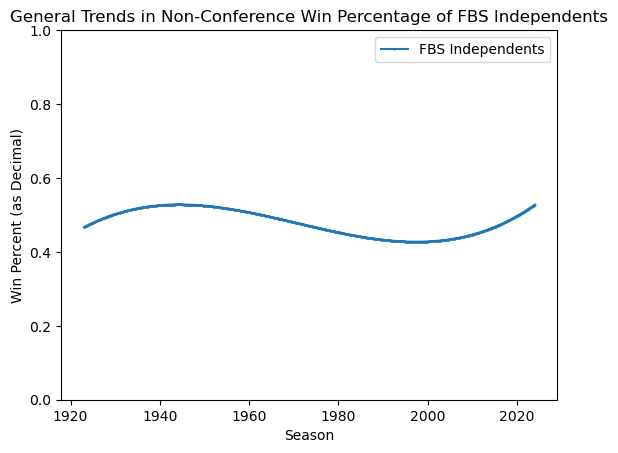

In [41]:

# independant
 
to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['FBS Independents'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of FBS Independents', 'independents.png')


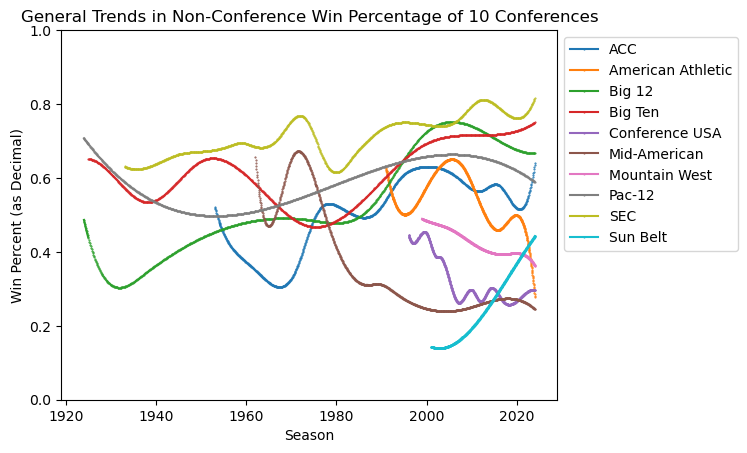

In [42]:
# Ten conferences 

to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of 10 Conferences', 'active.png')


# Furture Analysis
   1. Is there a correlation between program funding and program performance? Some of that data may not be accessible or readily available. The head coach salary might be a good proxy, but there could be issues with that as well. Another proxy might be the number of bowl games.
   2. The spread of win-loss percentages in the conference. ie. Are all teams of equal strength or do only a few stand out year to year?
   3. Take the current teams that are in the conferences now and recalculate the non-conference win percentages as if that was the conference 100 years ago. More of a team-group strength approach. A side project of this would be answering the "Dream Conference" question "What would the best team group of size X be if they were in the same conference for the last 100 years?"